# Applied Time Series - Filtering

This notebook is aimed to help me and maybe you understand filtering in time series better. The notebook is done in an R kernel with the aim of creating much nicer visuals than would be possible in Python with good time series data. This notebook will be a bit of an oddball as I hope to synthesize both technical exercises and details with applications as this topic is very pertinent for data scientists, quants, and everyone (hello Covid data).

The data set we will be working with is Texas county housing level data I scraped off of Texas A&M's website. The data was gathered in strings, so we had a little bit of cleaning to do.

In [84]:
# import libraries
library(lubridate)
library(tidyverse)

getData <- function(csv_loc) {
    # :param: csv_loc - string, texas county file paths
    # :return: df - dataframe, texas county data cleaned
    
    # reading in the csvs from the data folder
    df1 <- read.csv(paste(csv_loc, 'texas_counties1.csv', sep = '/'))
    df2 <- read.csv(paste(csv_loc, 'texas_counties2.csv', sep = '/'))
    df3 <- read.csv(paste(csv_loc, 'texas_counties3.csv', sep = '/'))

    # merging the csvs by the date column
    df <- rbind(df1, df2)
    df <- rbind(df, df3)
    
    # removing commas in price data
    comma_vars <- c('dollar_vol', 'avg_price', 'med_price')
    df[, comma_vars] <- sapply(df[, comma_vars],
                               function (x) as.numeric(gsub(",", "", x)))

    # changing dates to datetime objects
    df['date'] <- lapply(as.vector(df['date']),
                         function (x) as.Date(strptime(paste('01', x, sep = ''),
                                               '%d %b %Y')))
    
    # changing all price/listing columns to numeric
    numeric_cols <- c('sales', 'dollar_vol', 'avg_price', 'med_price',
                     'total_listings', 'month_inventory')
    df[, numeric_cols] <- sapply(df[, numeric_cols], as.numeric)

    # dropping the X column - accidental indexing
    df <- df[, names(df) != 'X']
}
                         
df <- getData('data')
head(df)

Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”
Warning message in lapply(X = X, FUN = FUN, ...):
“NAs introduced by coercion”


,date,sales,dollar_vol,avg_price,med_price,total_listings,month_inventory,county
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2011-01-01,15,1122600,74840,50000,344,31.0,Anderson
2,2011-02-01,20,1652300,82615,66950,371,30.1,Anderson
3,2011-03-01,25,3013550,120542,92000,372,27.1,Anderson
4,2011-04-01,25,2733350,109334,115000,365,24.1,Anderson
5,2011-05-01,27,2239161,82932,70000,387,23.8,Anderson
6,2011-06-01,21,1798605,85648,78000,421,23.9,Anderson


## About the Data and our Problem

Filtering and the problem of prediction in machine-learning go hand in hand. In this particular case, I believe our goal is to predict the average price column for the next quarter (3 months). This problem is tangible and relevant as if we can predict the average price for the next three months in a variety of Texas counties, then we have a great chance of being able to lever up and flip properties in the short-term picture - an interesting way of accruing wealth. Of course, this data set is simplified in the sense that I only include a few relevant variables - to spin this into your own personal project, consider adding macroeconomic variables that are indexed by quarter and month as well as more microeconomic variables like education level, companies in the city, average education level, etc!

Now first, it is sensible to perform some exploratory data analysis (EDA) to gain a sense of how exactly we should predict home prices (I will just cover filtering however).

Warning message:
“Removed 2 rows containing missing values (geom_point).”


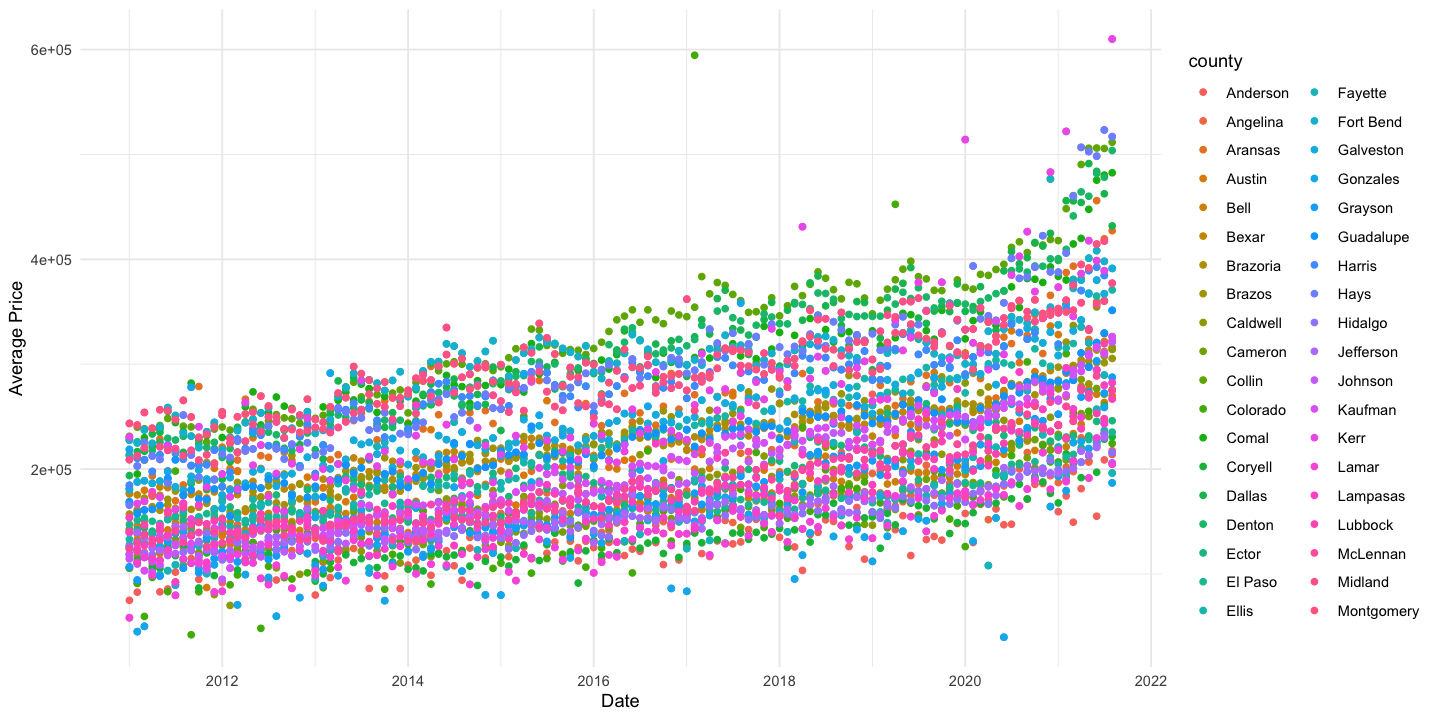

In [123]:
options(repr.plot.width = 12, repr.plot.height = 6)
ggplot(data = df) +
geom_point(aes(x = date, y = avg_price, color = county)) +
labs(x = 'Date', y = 'Average Price') + theme_minimal()

There's a noticeable linear trend with respect to time of our county data. Another interesting aspect is the fairly large dispersion among counties for average price - there are a few outliers on the positive end (that point in 2017 from Colin county) and a few on the positive and negative bands as we enter Covid where the housing dynamic across the nation experienced a phase change. As a side note, I would be curious if the time series has any cyclical bits - are home prices generally higher in the spring and come back down in the winter? Well, we plot that below and underwhelmingly there is very little change. If desirable, we could construct a hypothesis test of sorts to compare the data (a simple LRT or Wald test could suffice as data is sufficiently large).

Warning message:
“Removed 4771 rows containing non-finite values (stat_boxplot).”


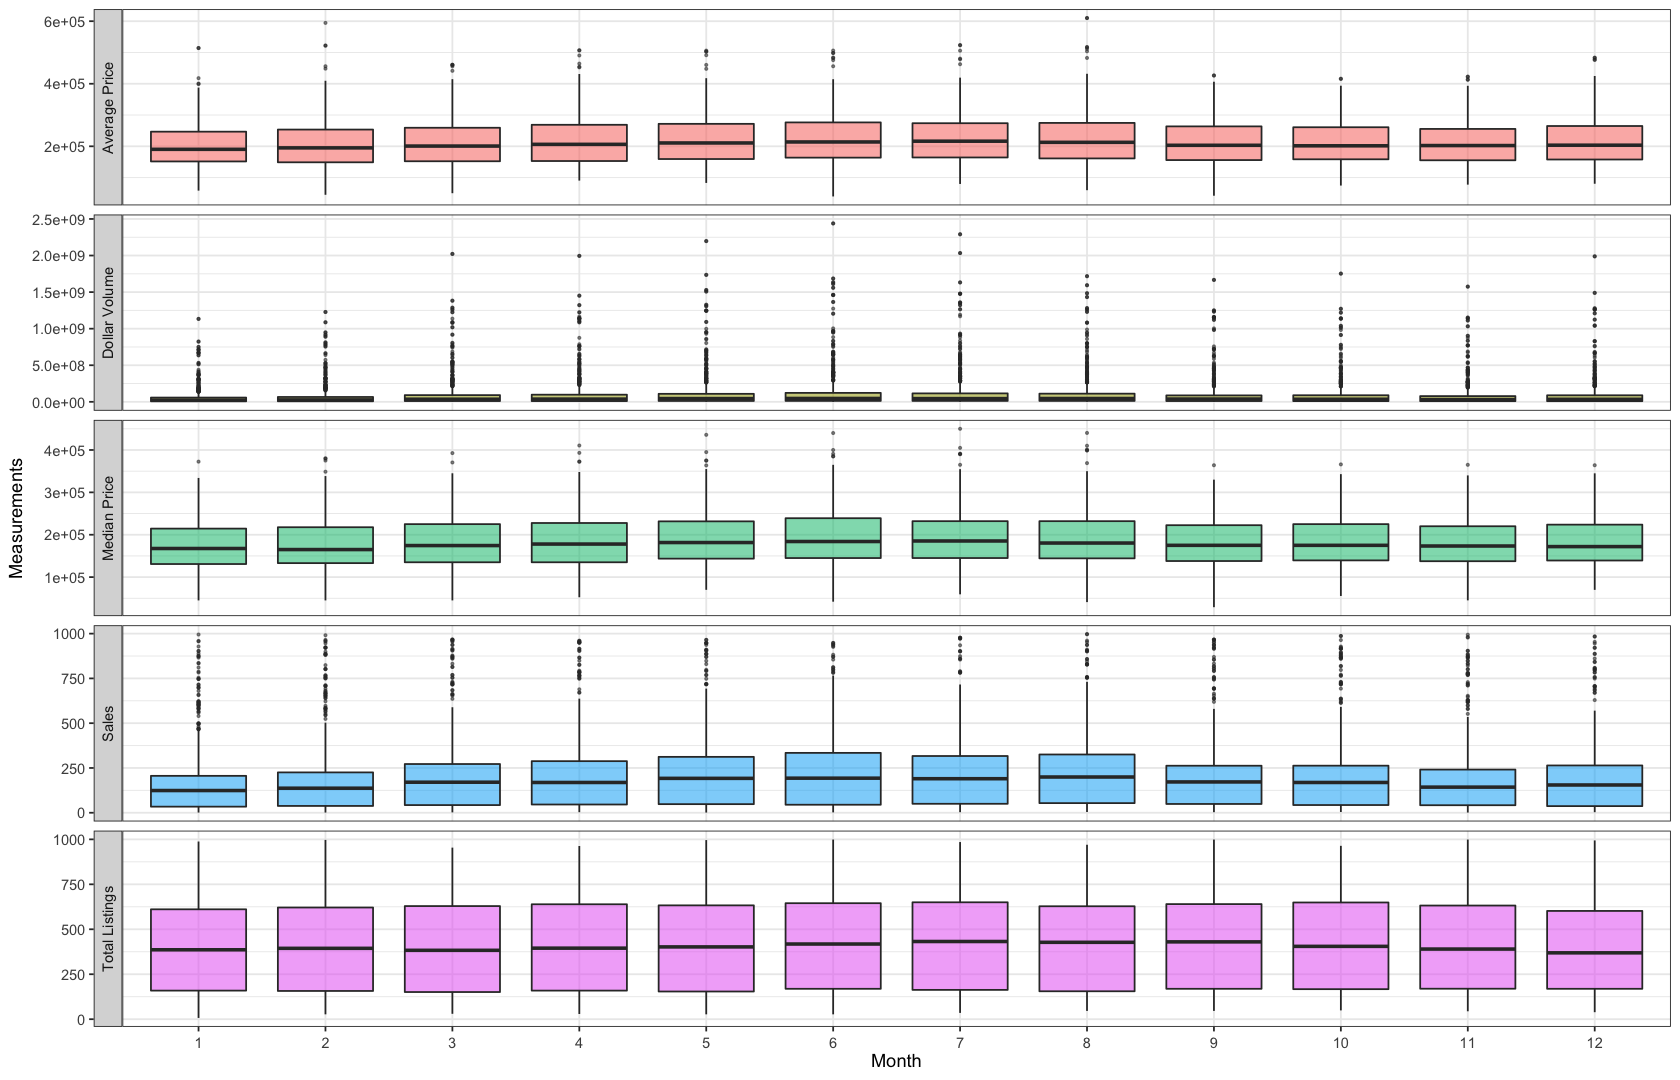

In [112]:
options(repr.plot.width = 14, repr.plot.height = 9)
df %>%
    mutate(month = factor(month(date))) %>%
    select(sales, dollar_vol, avg_price, med_price, total_listings, month) %>%
    gather('type', 'value', -c('month')) %>%
    ggplot() +
    geom_boxplot(aes(x = month, y = value, group = month, fill = type, alpha = 0.7),
                 outlier.size = 0.5) +
    labs(x = 'Month', y = 'Measurements', fill = 'Date') +
    scale_color_manual(values = c('sales' = '#80B1D3',
                                  'dollar_vol' = '#8DD3C7',
                                  'avg_price' = '#FDB462',
                                  'med_price' = '#FB8072',
                                  'total_listings' = '')) +
  theme_bw() + 
  theme(axis.text.x = element_text(angle = 0, vjust = 0.5),
        legend.position = "None") +
  facet_grid(rows = vars(type), 
             scales = 'free', 
             switch = 'y',
             labeller = as_labeller(c(`sales` = 'Sales',
                                      `dollar_vol` = 'Dollar Volume',
                                      `avg_price` = 'Average Price',
                                      `med_price` = 'Median Price',
                                      `total_listings` = 'Total Listings')))

In [113]:
summary(df)

      date                sales         dollar_vol          avg_price     
 Min.   :2011-01-01   Min.   :  1.0   Min.   :4.500e+04   Min.   : 39667  
 1st Qu.:2013-08-01   1st Qu.: 43.0   1st Qu.:9.848e+06   1st Qu.:156223  
 Median :2016-04-01   Median :163.0   Median :3.590e+07   Median :204636  
 Mean   :2016-04-14   Mean   :212.2   Mean   :1.241e+08   Mean   :215287  
 3rd Qu.:2018-12-01   3rd Qu.:282.0   3rd Qu.:9.474e+07   3rd Qu.:263978  
 Max.   :2021-08-01   Max.   :997.0   Max.   :2.439e+09   Max.   :610047  
                      NA's   :866     NA's   :2           NA's   :2       
   med_price      total_listings  month_inventory     county         
 Min.   : 29000   Min.   :  7.0   Min.   : 0.300   Length:7290       
 1st Qu.:138000   1st Qu.:162.0   1st Qu.: 2.500   Class :character  
 Median :175000   Median :400.0   Median : 3.500   Mode  :character  
 Mean   :184732   Mean   :416.3   Mean   : 4.372                     
 3rd Qu.:225574   3rd Qu.:631.0   3rd Qu.: 5.175  

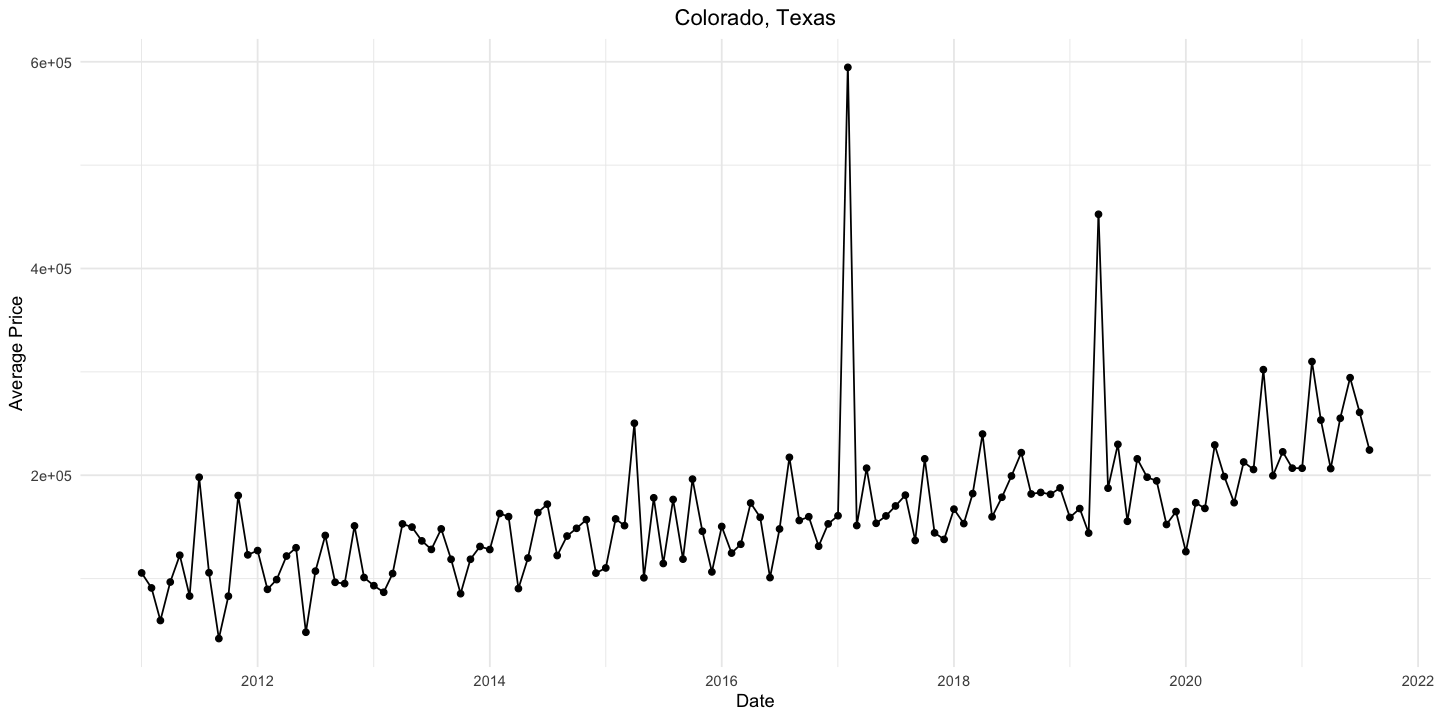

In [125]:
# state with outliers - some ugly place without local government
ggplot(data = df %>% filter(county == 'Colorado'), aes(x = date, y = avg_price)) +
geom_point() +
geom_line() +
labs(x = 'Date', y = 'Average Price', title = 'Colorado, Texas') +
theme_minimal() +
theme(plot.title = element_text(hjust = 0.5))

This place is causing a rucus with the instability of prices - on the Wikapedia page, it says that this particular county is unincorporated - meaning that there is no local government. I think that could add some color as to why the prices here are pretty unstable over time. For filtering, I say we exclude this... Now time to pivot to the actual filtering and math...

# State Space Formulation

asdf - Gelb ch3 & Chopin ch2

# Sources
- "Applied Optimal Estimation" - Arthur Gelb
- "An Introduction to Sequential Monte Carlo" - Chopin and Papaspiliopoulos
- https://waxworksmath.com/